<center><h1>Sartorius - Cell Instance Segmentation.</h1></center>

![img](https://storage.googleapis.com/kaggle-competitions/kaggle/30201/logos/header.png)

### **Semantic Segmentation: each pixel of an image is linked to a class label.**

![img](https://raw.githubusercontent.com/WaterKnight1998/SemTorch/develop/readme_images/semantic_segmentation.png)

### **Instance Segmentation: is similar to semantic segmentation, but goes a bit deeper, it identifies , for each pixel, the object instance it belongs to.**

![img](https://raw.githubusercontent.com/WaterKnight1998/SemTorch/develop/readme_images/instance_segmentation.png)

## Please don't forget to Upvote if like the work.

### if you fork the notebook please try to upvote it too.
**It keeps me motivated**



In [1]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.image as immg
from joblib import Parallel, delayed
import PIL,cv2,gc,os,sys,torch

In [2]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master/')
import timm

In [3]:
Path('/root/.cache/torch/hub/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp '../input/timmefficientnet/tf_efficientnet_b0_ns-c0e6a31c.pth' '/root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_ns-c0e6a31c.pth'

In [4]:
!cp '../input/resnet34/resnet34.pth' '/root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth'

In [5]:
!cp '../input/densenet121/densenet121.pth' '/root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth'

cp: cannot stat '../input/densenet121/densenet121.pth': No such file or directory


## Data already broken down into 2x2 tiles to increase dataset, and faster training

https://www.kaggle.com/robertlangdonvinci/sartorius-cell-segmentation-data-gen/notebook

### Since data is broked into 2x2 tile some tiles contain no masks we will clean them up.

In [6]:
path = Path('../input/sartoriuscellinstancesegmentationmaskpng')

In [7]:
def label_func(fn): return f"/kaggle/input/sartoriuscellinstancesegmentationmaskpng/TrainMask2x2/{fn.stem}_mask.png"

In [8]:
img_files = get_image_files(path/'TrainImage2x2')

In [9]:
img_files_clean = [] 
for f in tqdm(img_files):
    loc = label_func(f)
    img = np.unique(np.array(Image.open(loc)))
    if len(img)!=1:
        img_files_clean.append(f)

  0%|          | 0/2424 [00:00<?, ?it/s]

In [10]:
len(img_files),len(img_files_clean)

(2424, 2414)

In [11]:
img_files = img_files_clean 

In [12]:
n = np.random.randint(0,100)
img = PIL.Image.open(img_files[n])
mask = PIL.Image.open(label_func(img_files[n]))

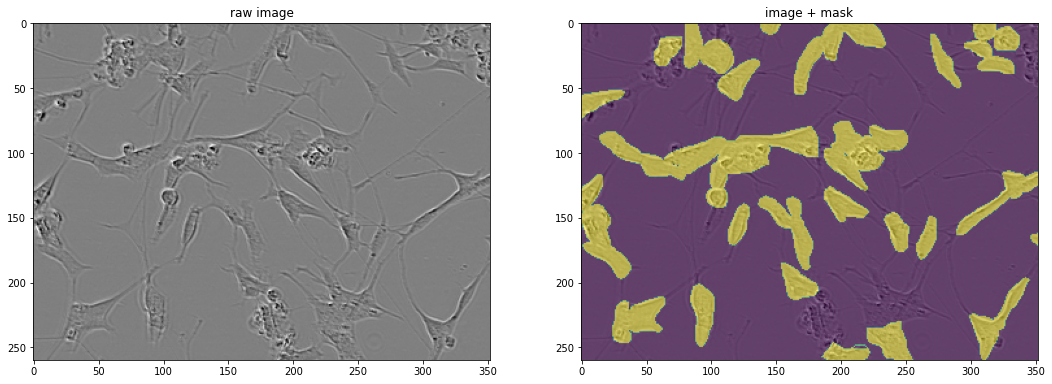

In [13]:
plt.figure(1,figsize=(18,8))
plt.subplot(121)
plt.imshow(img)
plt.title('raw image')
plt.subplot(122)
plt.imshow(img)
plt.imshow(mask,alpha=0.5);
plt.title('image + mask');

In [14]:
img_path = Path('../input/sartoriuscellinstancesegmentationmaskpng/TrainImage2x2')

In [15]:
def get_classes(fnames):
    class_codes=[]
    for i in tqdm(range(len(fnames))):
        class_codes += list(np.unique(np.asarray(Image.open(label_func(fnames[i])))))
    return np.array(list(set(class_codes)))

In [16]:
codes = get_classes(img_files);codes

  0%|          | 0/2414 [00:00<?, ?it/s]

array([0, 1, 2, 3], dtype=uint8)

In [17]:
mask.shape

(260, 352)

## Creating A dataloader

In [18]:
def label_func2(fn): 
    fn = Path(fn)
    img = np.array(Image.open(f"../input/sartoriuscellinstancesegmentationmaskpng/TrainMask2x2/{fn.stem}_mask.png"))
    img = img.clip(0,1)
    return img

In [19]:
dls = dls = SegmentationDataLoaders.from_label_func(img_path, bs=8, 
                                                    fnames = img_files,
                                                    label_func = label_func2, 
                                                    codes = [0,1])

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


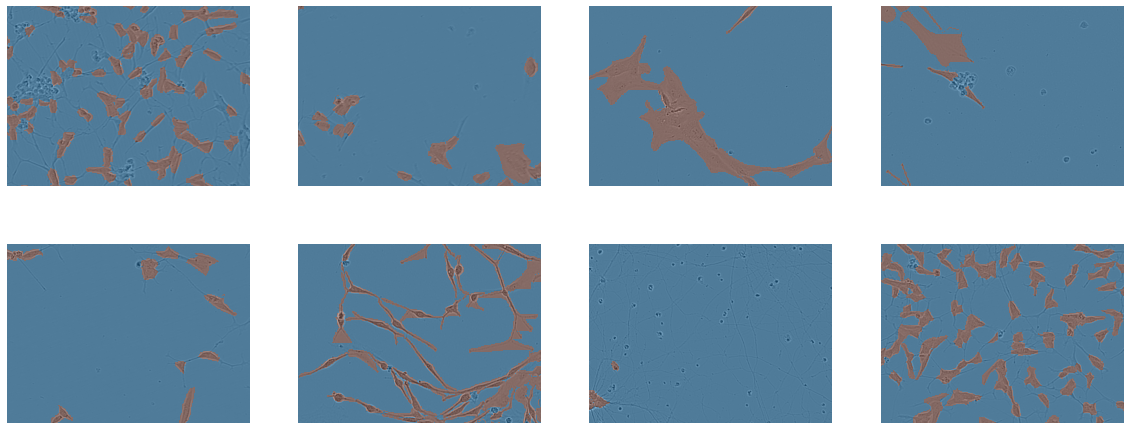

In [20]:
dls.show_batch(max_n=8,figsize=(20,8))

In [21]:
len(dls.train_ds),len(dls.valid_ds)

(1932, 482)

In [22]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = -1

def cell_mask_accuracy(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [23]:
acc = cell_mask_accuracy

## IoU metrics

In [24]:
# https://forums.fast.ai/t/multi-class-semantic-segmentation-metrics-and-accuracy/74665/4
# Return Jaccard index, or Intersection over Union (IoU) value
def IoU(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

## Creating a UNet Learner

**This module builds a dynamic U-Net from any backbone pretrained on ImageNet, automatically inferring the intermediate sizes.**

***

![dynamicUnet](https://fastai1.fast.ai/imgs/u-net-architecture.png)

***

**This is the original U-Net. The difference here is that the left part is a pretrained model.**

https://fastai1.fast.ai/vision.models.unet.html

In [25]:
from timm import create_model 

In [26]:
model = create_model('tf_efficientnet_b0_ns', 
                     pretrained=True, 
                     )

In [27]:
learn = unet_learner(dls,resnet34, model_dir='/kaggle/working/',metrics=[acc,Dice(),IoU]).to_fp16()

* Launch a mock training to find a good learning rate

SuggestedLRs(valley=0.0006918309954926372)

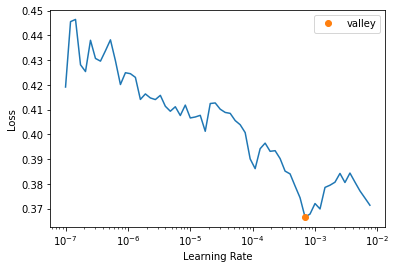

In [28]:
learn.lr_find()

In [29]:
gc.collect()

36373

* Start your training

In [30]:
cb1 = SaveModelCallback(monitor='dice',fname='best_model',comp=np.greater) # Callbacks
cb2 = ReduceLROnPlateau(monitor='dice', patience=1,factor=0.2)
learn.fine_tune(10, 3.0199516913853586e-05,cbs = [cb1,cb2])

epoch,train_loss,valid_loss,cell_mask_accuracy,dice,IoU,time
0,0.208821,0.199464,0.913567,0.382105,0.578373,01:33


Better model found at epoch 0 with dice value: 0.3821046338583117.


epoch,train_loss,valid_loss,cell_mask_accuracy,dice,IoU,time
0,0.161240,0.156198,0.931292,0.669211,0.628494,01:38
1,0.159976,0.152963,0.933478,0.704712,0.640253,01:38
2,0.156041,0.154568,0.932992,0.606001,0.640750,01:38
3,0.135040,0.135764,0.942250,0.701524,0.672227,01:38
4,0.127435,0.135261,0.943434,0.714736,0.686389,01:38
5,0.120274,0.135540,0.943059,0.698106,0.681918,01:38
6,0.127833,0.127719,0.946168,0.731185,0.695176,01:38
7,0.118715,0.127726,0.945891,0.743327,0.695589,01:38
8,0.111861,0.126879,0.946566,0.741312,0.698480,01:38
9,0.112450,0.126182,0.946642,0.744531,0.698704,01:38


Better model found at epoch 0 with dice value: 0.6692110662391173.
Better model found at epoch 1 with dice value: 0.7047120393559496.
Better model found at epoch 4 with dice value: 0.7147364867437115.
Better model found at epoch 6 with dice value: 0.7311849233742737.
Better model found at epoch 7 with dice value: 0.7433268698227754.
Better model found at epoch 9 with dice value: 0.7445309885774117.


In [31]:
"""class Encoder(Module):
    def __init__(self ,model_name='tf_efficientnet_b0'):
        self.encoder = timm.create_model(model_name,features_only=True,pretrained=True)
    def forward(self,x):
        return self.encoder(x)"""

"class Encoder(Module):\n    def __init__(self ,model_name='tf_efficientnet_b0'):\n        self.encoder = timm.create_model(model_name,features_only=True,pretrained=True)\n    def forward(self,x):\n        return self.encoder(x)"

In [32]:
"""timm_models = timm.list_models(pretrained=True)"""

'timm_models = timm.list_models(pretrained=True)'

In [33]:
learn.load('/kaggle/working/best_model');

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [34]:
try:
    learn.export('/kaggle/working/resnet34.pkl')
except:
    pass

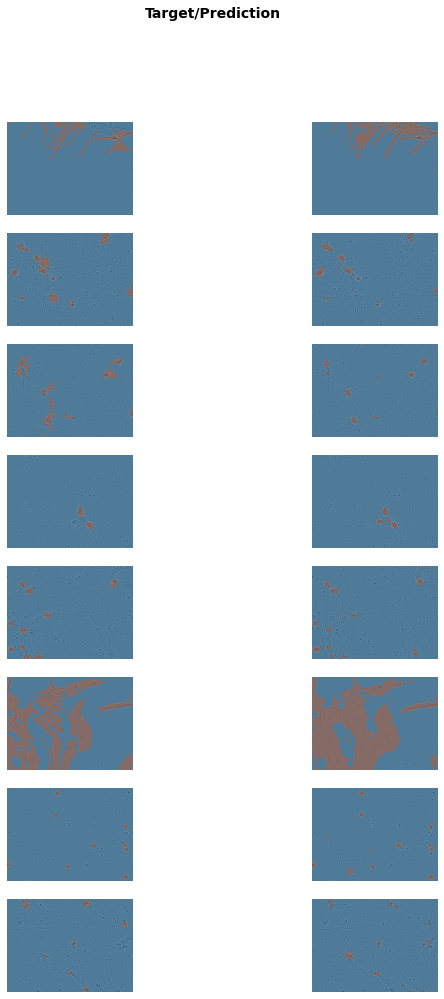

In [35]:
learn.show_results(max_n = 8, figsize = (10,16) )

## our top 3 losses

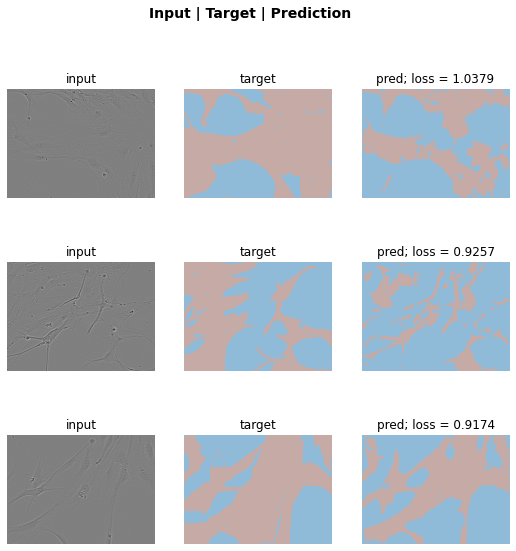

In [36]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

## Loading Submission files and predicting results

In [37]:
submission = pd.read_csv('../input/sartorius-cell-instance-segmentation/sample_submission.csv')
submission.head()

,id,predicted
0,7ae19de7bc2a,NaN
1,d48ec7815252,NaN
2,d8bfd1dafdc4,NaN


In [38]:
test_data_path = submission['id'].apply(lambda x:f'../input/sartorius-cell-instance-segmentation/test/{x}.png').tolist()

In [39]:
tst_dl = learn.dls.test_dl(test_data_path)
preds = learn.get_preds(dl = tst_dl)[0]

In [40]:
prediction_masks = [x.argmax(axis=0) for x in preds]

## A look at test predictions

In [41]:
im_num = 0
ts_img = PIL.Image.open(test_data_path[im_num])
ts_mask = prediction_masks[im_num]

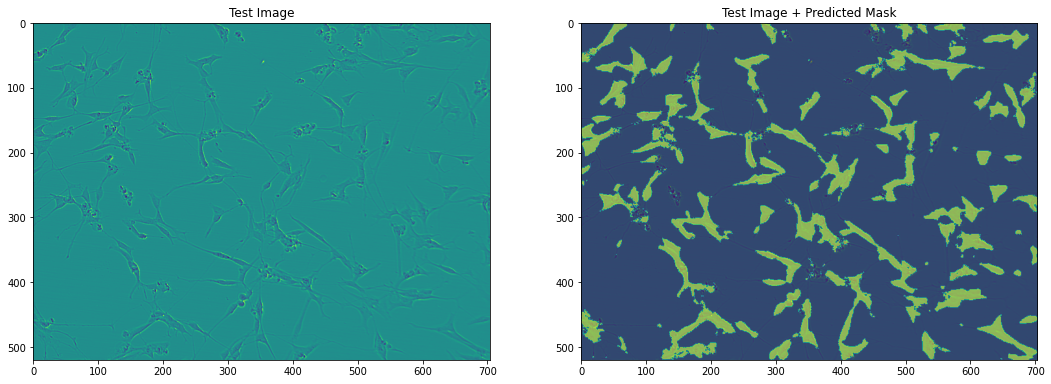

In [42]:
plt.figure(1,figsize=(18,8))
plt.subplot(121)
plt.imshow(ts_img)
plt.title('Test Image')
plt.subplot(122)
plt.imshow(ts_img)
plt.imshow(ts_mask,alpha=0.5);
plt.title('Test Image + Predicted Mask');

## Converting predicted semantic masks to instance masks and then to run length encodings

**Since fastai only provides semantic segmentation we will use a hack to convert it into intance segmentation masks**

**We will use an algorithm called connected components algorithm to convert semantic mask to instance mask**

**Connected Component Labeling (CCL)** is a basic algorithm in image processing and an essential step in nearly every application dealing with object detection. It groups together pixels belonging to the same connected component

![ccl](https://homepages.inf.ed.ac.uk/rbf/HIPR2/labelb.gif)

In [43]:
def CCL(img_arr):
    img = img_arr
    # Converting those pixels with values 1-127 to 0 and others to 1
    #img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]
    # Applying cv2.connectedComponents() 
    num_labels, labels = cv2.connectedComponents(img)
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    ret_lbl = labeled_img.copy()
    return ret_lbl[:,:,0]

In [44]:
is_mask = np.expand_dims(prediction_masks[im_num].numpy(),axis=-1).astype(np.uint8)
is_img = CCL(is_mask)

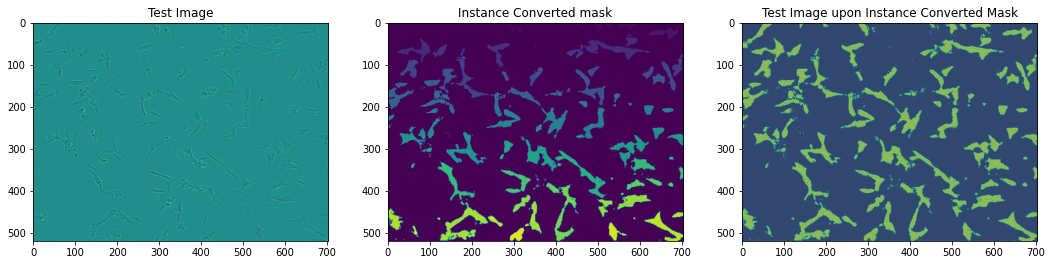

In [45]:
plt.figure(1,figsize=(18,8))
plt.subplot(131)
plt.imshow(ts_img)
plt.title('Test Image')
plt.subplot(132)
plt.imshow(is_img)
plt.title('Instance Converted mask')
plt.subplot(133)
plt.imshow(ts_img)
plt.imshow(is_mask,alpha=0.5);
plt.title('Test Image upon Instance Converted Mask');

**See how CCL algorithm has colored each mask with a different color**

In [46]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [47]:
def convert_seg_ins(img_f):
    lbl_img1 = img_f.copy()
    grps = list(np.unique(lbl_img1))
    grps.remove(0)
    all_masks = []
    shape = (520,704)
    for g in grps:
        a = np.where(((lbl_img1!=0)&(lbl_img1!=g)),np.zeros(shape),lbl_img1)
        all_masks.append(a.clip(0,1))
    all_masks = np.array(all_masks)
    return all_masks

### Writing masks to rle

In [48]:
sub_ids = submission['id'].values

In [49]:
res = []
n = 0
for i in tqdm(range(len(prediction_masks))):
    chk_mask = np.expand_dims(prediction_masks[i].numpy(),axis=-1).astype(np.uint8)
    lbl_img = CCL(chk_mask)
    pred_masks = convert_seg_ins(lbl_img)
    for mask in pred_masks:
        ts = np.unique(mask, return_counts=True)[1][1]
        #removing blocks with very small areas
        if ts>50:
            res.append([sub_ids[i],rle_encode(mask)])

  0%|          | 0/3 [00:00<?, ?it/s]

In [50]:
sub_df = pd.DataFrame(res,columns=['id', 'predicted'])

In [51]:
sub_df.head()

,id,predicted
0,7ae19de7bc2a,143 1 845 5 1546 9 2251 7 2955 6 3658 7 4362 7 5066 7 5770 6 6474 5 7178 5 7882 4 8586 4 9290 3
1,7ae19de7bc2a,197 4 899 5 1601 8 2306 6 3011 6 3714 7 4418 9 5122 10 5826 10 5837 1 6531 11 7235 11 7941 1 7944 1 7948 2 8645 1
2,7ae19de7bc2a,278 1 449 2 982 6 1152 4 1686 10 1697 1 1855 6 2390 15 2559 8 3095 14 3263 10 3799 14 3967 10 4503 16 4673 8 5207 16 5376 4 5381 4 5912 17 6083 8 6616 18 6787 8 7321 19 7491 9 8025 18 8195 10 8730 16 8747 3 8901 4 8906 2 9435 14 9451 2 9605 2 9608 1 9611 1 10140 14 10157 2 10315 1 10845 13 10860 3 11549 18 12254 16 12958 16 13663 14 14367 14 15072 13 15778 11 16482 11 17188 9 17893 2 17896 5 18596 9 19301 8 20006 7 20710 7 21414 7 22118 6 22823 3 23527 2
3,7ae19de7bc2a,495 2 502 1 1194 3 1198 10 1897 17 2603 14 3309 2 3312 9 4006 2 4010 1 4013 14 4709 3 4713 19 5413 25 6118 1 6120 23 6824 23 7533 18 8239 16 8944 16 9648 17 10352 17 11056 17 11761 15 12464 15 13168 9 13179 4 13872 9 14575 10 15279 10 15984 9 16688 7 17392 7 18096 7 18801 5 19508 1 20212 2
4,7ae19de7bc2a,566 9 580 8 1267 12 1280 12 1969 28 2672 29 3369 36 4070 39 4771 43 5473 47 6177 48 6881 48 7586 46 8291 37 8334 2 8999 10 9019 10 9039 1 9724 9 10430 2 10433 4 11137 4 11842 3 12545 6 13251 5 13955 4 13960 1 14661 4 15365 3


In [52]:
sub_df.to_csv('submission1.csv',index=False)

## Please don't forget to Upvote if like the work.

In [53]:
sub_df['id'].value_counts()

7ae19de7bc2a    74
d48ec7815252    24
d8bfd1dafdc4    15
Name: id, dtype: int64